# Model A: PyTorch Implementation from Keras (for GPU)

### Model A : Resnet CNN Without any Transformer for CLassifying Potato Diseases
This notebook contains our solution using the approach: Deep learning based approaches that do not employ transformer architechtures
Our approach used the model of Resnet without the pretain to follow the "Closed Mode" Principle

# Methodology
Our methodology for this project involves the following steps:

## 1. Setting up the seed and the CPU/GPU dependencies
For reproducibility and make the gpu work for training
## 2. Extracting and Preprocessing Images
From the zip file, the dataset is extracted and cleaned based on the correct filetype, also deleting corruptfiles. The images are resized to 224 x 224 pixels and normalizing them to the image.net values. The Train Data was augmented to have verticalflip, horizontalflip, random rotation, color jitter, and gaussian blur to aviod overfitting and make the model not memorize the data. The validation dataset would not have an augmentation. We also used an 80-20 split train-validation dataset since test data set will be given later.
## 3. Building the Model
Our model uses the Resnet CNN model with pretrained = false for no weights will be used from online source, which is we will have a scratch resnet model. We replaced the head of the resnet to have a drop out of 50% to avoid overfitting. We also used AdamW optimizers, a scheduler that will reduce Learning rates on plateu and an criterion with entrophyloss.
## 4. Training the Model
Our model trains for 50 epochs with a patience of 5 if there is no improvement from the validation accuracy. Also the train accuracy and validation accuracy is printed to check for overfitting and plateu for manual stopping. Each Epoch shows an increase in accuracy for both values per epoch and the stopping ensures that each epochs, the model learns and if it doesnt, it will stop.
## 5. Fine-tuning the model
Fine-tuning the model has different parameters in the optimizers, with the adamW, it gives different learning rates to the different layers of the resnet. This allows fine tuning the model for a different learnings and increase accuracy while preventing overfitting, this showed atleast 2% improvement in accuracy.
## 6. Evaluating the Model
Evaluating the Model through the precision, f1 scores, stability, recall, accuracy and specificity is printed at the end. Evaluation per class, we can see which classes this model classifies the best and which are not. We also have graph for the train vs validity values aswell as the confusion matrices, these finds whether there is overfitting and find the confusion between classes
## 7. Prediction using the test dataset
ALthough not included in this file, the demo_deeplearning_cnn has the notebook code to run and use the model to predict the test dataset given and gives a csv of the predictions per image.


## Import the potato development set

In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip install opencv-python
%pip install matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Extract the potato_train ZIP file

In [2]:
import zipfile
import os

# Path to potato_train.zip (assumed: same level dir as .ipynb)
zip_path = "potato_train.zip"

# Extract if not already extracted
extract_dir = "potato_train"

if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

print("Dataset extracted to:", extract_dir)

Dataset extracted to: potato_train


## Unzip the potato development set

In [3]:
import zipfile

zip_ref = zipfile.ZipFile("potato_train.zip")
zip_ref.extractall()
zip_ref.close()

# Import Libraries

In [4]:
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import os

import random

## Set fixed randomized seed for reproducibiltiy

In [5]:
# Set seed here as well
def set_seed(seed=42):
    random.seed(seed)                      # Python random module
    np.random.seed(seed)                   # NumPy
    torch.manual_seed(seed)                # PyTorch CPU
    torch.cuda.manual_seed(seed)           # PyTorch GPU
    torch.cuda.manual_seed_all(seed)       # PyTorch multi-GPU

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

## Check and ensure proper CPU/GPU dependencies

In [6]:
# Check CPU/GPU dependencies
torch.cuda.empty_cache()

print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Cached memory:    {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

# Run the code using the GPU; caution: might burn 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Allocated memory: 0.00 MB
Cached memory:    0.00 MB
Using device: cuda


# Image Preprocessing

## Filter out corrupted images

In [7]:
dataset_root = "train" # actual unzipped folder of the development images; standardized name set by sir, i.e., "train"

num_skipped = 0
for folder_name in os.listdir(dataset_root): # "Bacteria", "Fungi", "Healthy", "Pest", "Phytopthora", "Virus"
    folder_path = os.path.join(dataset_root, folder_name)
    if not os.path.isdir(folder_path):
        continue

    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            with open(fpath, "rb") as fobj:
                head = fobj.read(10)
                is_jfif = b"JFIF" in head
        except Exception:
            is_jfif = False

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print(f"Deleted {num_skipped} files that were not JFIF images.")

Deleted 0 files that were not JFIF images.


## Data Augmentation (Training) and Preprocessing (Validation)

In [8]:
image_size = 224
batch_size = 16
num_classes = 6

# ImageNet mean and std (for pretrained ResNet)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=5, sigma = (0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    transforms.RandomErasing(p=0.05, scale = (0.02,0.2))
])

transform_val = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

## Train/Validation Split and DataLoader Setup

In [9]:
# Load the full dataset with training transformations
full_dataset = datasets.ImageFolder(root=dataset_root, transform=transform_train)

# Calculate sizes for training and validation sets (80/20 split)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Randomly split the data set into training and validation sets
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Use validation transform for validation dataset
val_dataset.dataset.transform = transform_val

# Create dataloaders for training and validation sets

# For training: shuffle=True to randomize the order of data at each epoch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
# For validation: shuffle=False to keep validation data in same order for reproducibility during eval.
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Visualize the data

## Visualize Training Images Batch with Class Labels

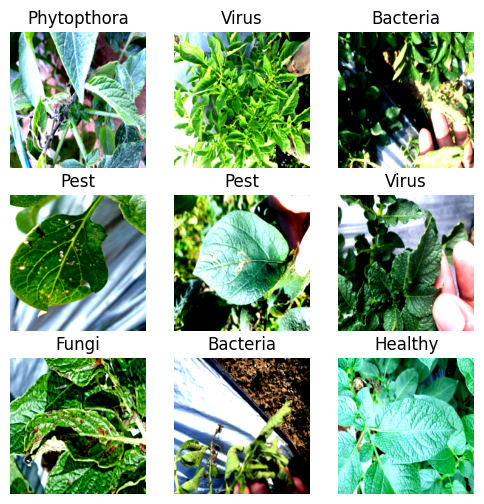

In [10]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp * 0.5 + 0.5, 0, 1)  # unnormalize
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis("off")

class_names = full_dataset.classes

inputs, classes = next(iter(train_loader))
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3,3,i+1)
    imshow(inputs[i])
    plt.title(class_names[classes[i].item()])

# Build the model

## Load ResNet50 base model (from scratch; pretrained=False)

In [11]:
# Load pre-trained ResNet50 model (from ImageNet)
resnet = models.resnet50(pretrained=False) # ! pretrained=False -> ensures that it follows Project specs, i.e., CLOSED shared tasks

# Replace final fully connected layer with a custom classifier with 50% dropout (for overfitting) and dense layer to revert back to # of classes (6)
resnet.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet.fc.in_features, num_classes)
)

# Move model to device, i.e., to ensure GPU is used if available... otherwise, affixed to CPU (CAVEAT: may detrimentally affect CPU though)
resnet = resnet.to(device)

c:\Users\gerar\OneDrive\Documents\5 UP 3.2\CS 180\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gerar\OneDrive\Documents\5 UP 3.2\CS 180\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Define loss function and optimizer

In [12]:
criterion = nn.CrossEntropyLoss()

# Pass all model params
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)


## Train the model with early stopping 

In [13]:
epochs = 50
best_val_acc = 0
patience = 4
patience_counter = 0

for epoch in range(epochs):
    # Set model to training mode
    resnet.train()
    correct = 0
    for inputs, labels in train_loader:
        
        # Move input tensors to computation device (either CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Clear gradients of all optimized parameters
        optimizer.zero_grad()

        # Get predicted outputs from model
        outputs = resnet(inputs)

        # Compute loss from predictions to true labels
        loss = criterion(outputs, labels)

        # Perform backpropagation to compute gradients of loss with respect to model parameters
        loss.backward()

        # Update model params using computed gradients on optimizer's algorithm
        optimizer.step()

        # Count/update correct predictions in training
        correct += (outputs.argmax(1) == labels).sum().item()

    # Set model to evaluation mode
    val_loss = 0
    val_correct = 0
    resnet.eval()

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)

            # Add batch loss to total validation loss
            val_loss += loss.item()

            # Count/update correct predictions in validation
            val_correct += (outputs.argmax(1) == labels).sum().item()

    # Calculate training and validation accuracy
    train_acc = correct / len(train_dataset)
    val_acc = val_correct / len(val_dataset)
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_loss = val_acc
        torch.save(resnet.state_dict(), "deeplearning_cnn.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
        
    scheduler.step(val_acc)
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")

Epoch 1/50 - Train Acc: 0.3072 - Val Acc: 0.3524
Current LR: 1.00e-03
Epoch 2/50 - Train Acc: 0.3644 - Val Acc: 0.3229
Current LR: 1.00e-03
Epoch 3/50 - Train Acc: 0.4162 - Val Acc: 0.4483
Current LR: 1.00e-03
Epoch 4/50 - Train Acc: 0.4111 - Val Acc: 0.3672
Current LR: 1.00e-03
Epoch 5/50 - Train Acc: 0.4439 - Val Acc: 0.4576
Current LR: 1.00e-04
Epoch 6/50 - Train Acc: 0.4928 - Val Acc: 0.5387
Current LR: 1.00e-04
Epoch 7/50 - Train Acc: 0.5238 - Val Acc: 0.5572
Current LR: 1.00e-04
Epoch 8/50 - Train Acc: 0.5229 - Val Acc: 0.5609
Current LR: 1.00e-05
Epoch 9/50 - Train Acc: 0.5570 - Val Acc: 0.6033
Current LR: 1.00e-05
Epoch 10/50 - Train Acc: 0.5741 - Val Acc: 0.5959
Current LR: 1.00e-05
Epoch 11/50 - Train Acc: 0.5815 - Val Acc: 0.6089
Current LR: 1.00e-06
Epoch 12/50 - Train Acc: 0.5667 - Val Acc: 0.6162
Current LR: 1.00e-06
Epoch 13/50 - Train Acc: 0.5792 - Val Acc: 0.6144
Current LR: 1.00e-06
Epoch 14/50 - Train Acc: 0.5824 - Val Acc: 0.6199
Current LR: 1.00e-07
Epoch 15/50 - T

## Fine-tune the entire model

In [14]:
# Initialize lists to store metrics for plotting
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

epochs = 30
patience = 5  # You can adjust this
optimizer = optim.AdamW([
    {'params': resnet.layer3.parameters(), 'lr': 1e-5},  # Lower LR for early layers
    {'params': resnet.layer4.parameters(), 'lr': 3e-5},  # Slightly higher for mid layers
    {'params': resnet.fc.parameters(), 'lr': 1e-4}      # Highest for new classifier
], weight_decay=1e-4)
# Initialize variables for confusion matrix
all_labels = []
all_preds = []

for epoch in range(epochs):
    resnet.train()
    correct = 0
    total_loss = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total_loss += loss.item() * inputs.size(0)

    train_acc = correct / len(train_dataset)
    train_loss = total_loss / len(train_dataset)
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)

    # Validation phase
    val_loss = 0
    val_correct = 0
    resnet.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            
            # Store for confusion matrix
            if epoch == epochs - 1:  # Only store last epoch
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

    val_acc = val_correct / len(val_dataset)
    val_loss = val_loss / len(val_dataset)
    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)

    print(f"[Epoch {epoch+1}/{epochs}] Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping and model saving
    if val_acc < best_val_loss:
        best_val_loss = val_acc
        torch.save(resnet.state_dict(), "deeplearning_cnn.pt")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    scheduler.step(val_loss)
    if epoch == 0:
        for g in optimizer.param_groups:
            g['lr'] = 1e-4
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e}")

[Epoch 1/30] Train Acc: 0.5769, Val Acc: 0.6015 | Train Loss: 1.0674, Val Loss: 1.0516
Current LR: 1.00e-04
[Epoch 2/30] Train Acc: 0.5824, Val Acc: 0.6125 | Train Loss: 1.0689, Val Loss: 1.0422
Current LR: 1.00e-04
[Epoch 3/30] Train Acc: 0.5866, Val Acc: 0.6125 | Train Loss: 1.0579, Val Loss: 1.0219
Current LR: 1.00e-04
[Epoch 4/30] Train Acc: 0.5866, Val Acc: 0.5978 | Train Loss: 1.0208, Val Loss: 1.0282
Current LR: 1.00e-04
[Epoch 5/30] Train Acc: 0.6028, Val Acc: 0.6015 | Train Loss: 0.9982, Val Loss: 1.0315
Current LR: 1.00e-04
[Epoch 6/30] Train Acc: 0.6120, Val Acc: 0.6199 | Train Loss: 0.9983, Val Loss: 0.9971
Current LR: 1.00e-04
[Epoch 7/30] Train Acc: 0.6268, Val Acc: 0.6125 | Train Loss: 0.9658, Val Loss: 0.9877
Current LR: 1.00e-04
[Epoch 8/30] Train Acc: 0.6402, Val Acc: 0.6236 | Train Loss: 0.8949, Val Loss: 1.0223
Current LR: 1.00e-04
[Epoch 9/30] Train Acc: 0.6933, Val Acc: 0.6236 | Train Loss: 0.8181, Val Loss: 0.9752
Early stopping at epoch 9


Note: you may need to restart the kernel to use updated packages.

Classification Report:
              precision    recall  f1-score   support

    Bacteria     0.9043    0.8947    0.8995        95
       Fungi     0.5680    0.5182    0.5420       137
     Healthy     0.5714    0.1250    0.2051        32
        Pest     0.4539    0.5818    0.5100       110
 Phytopthora     0.6250    0.6250    0.6250        72
       Virus     0.6699    0.7188    0.6935        96

    accuracy                         0.6236       542
   macro avg     0.6321    0.5773    0.5792       542
weighted avg     0.6296    0.6236    0.6161       542



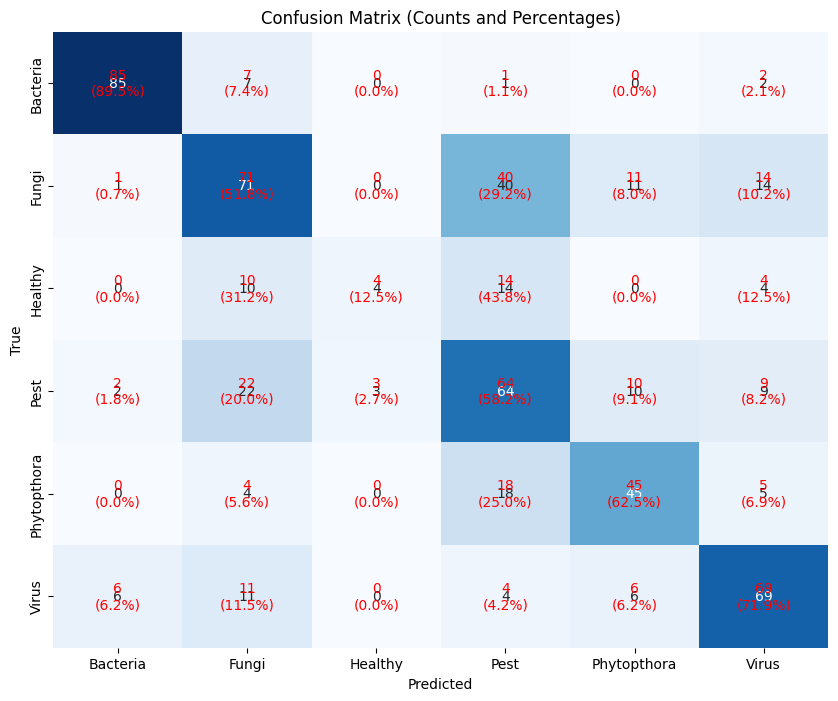

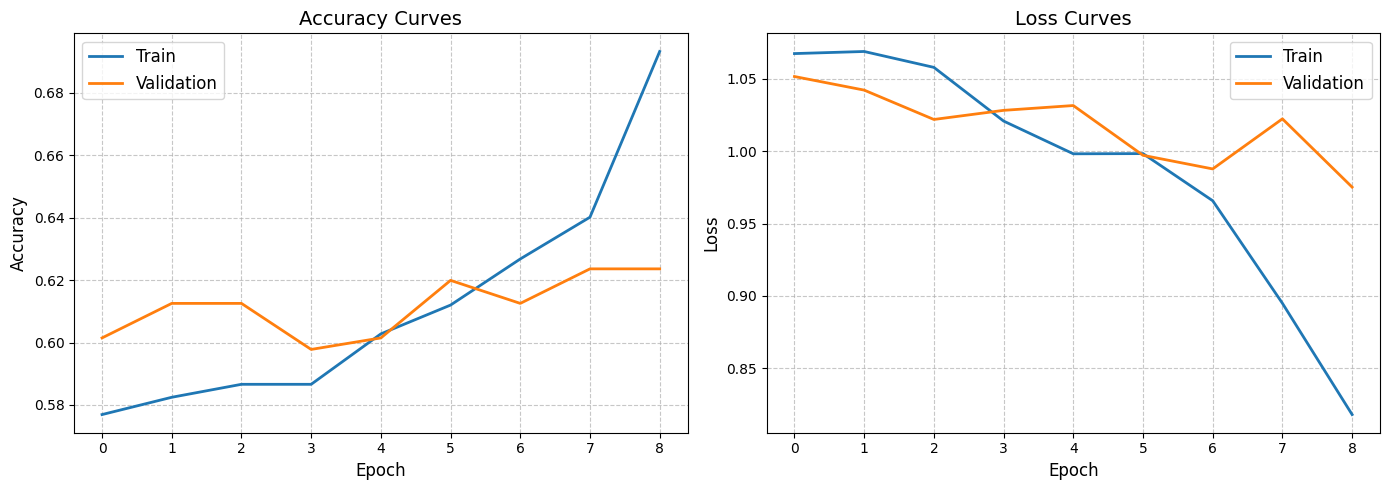


Detailed Class Metrics:
+--------------+-------------+-------------+----------+------------+---------------+
|              | Class       |   Precision |   Recall |   F1-Score |   Specificity |
+==============+=============+=============+==========+============+===============+
| 0            | Bacteria    |      0.9043 |   0.8947 |     0.8995 |        0.9831 |
+--------------+-------------+-------------+----------+------------+---------------+
| 1            | Fungi       |      0.5680 |   0.5182 |     0.5420 |        0.8866 |
+--------------+-------------+-------------+----------+------------+---------------+
| 2            | Healthy     |      0.5714 |   0.1250 |     0.2051 |        0.9942 |
+--------------+-------------+-------------+----------+------------+---------------+
| 3            | Pest        |      0.4539 |   0.5818 |     0.5100 |        0.8448 |
+--------------+-------------+-------------+----------+------------+---------------+
| 4            | Phytopthora |      0.62

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import pandas as pd
%pip install tabulate

# Ensure we have predictions and labels
if len(all_labels) == 0 or len(all_preds) == 0:
    # Collect all predictions if not already done
    all_labels = []
    all_preds = []
    resnet.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

# Get the actual class labels present in the data
unique_labels = np.unique(all_labels)
num_classes = len(unique_labels)

# If class_names isn't defined or doesn't match, create generic ones
if 'class_names' not in locals() or len(class_names) != num_classes:
    class_names = [f'Class {i}' for i in range(num_classes)]

# 1. Classification Report
print("\nClassification Report:")
print(classification_report(
    all_labels, 
    all_preds, 
    target_names=class_names, 
    digits=4,
    zero_division=0  # Handle cases where division by zero might occur
))

# 2. Enhanced Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=class_names, 
    yticklabels=class_names,
    cbar=False
)

# Add percentages to confusion matrix
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j+0.5, i+0.5, f"{cm[i,j]}\n({cm_percent[i,j]:.1%})",
                ha='center', va='center', color='red')

plt.title('Confusion Matrix (Counts and Percentages)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
plt.show()

# 3. Enhanced Training Plots
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train', linewidth=2)
plt.plot(val_acc_history, label='Validation', linewidth=2)
plt.title('Accuracy Curves', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train', linewidth=2)
plt.plot(val_loss_history, label='Validation', linewidth=2)
plt.title('Loss Curves', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig('training_metrics.png', bbox_inches='tight', dpi=300)
plt.show()

# 4. Complete Metrics Analysis
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, 
    all_preds, 
    average=None,  # Get metrics for each class
    zero_division=0
)

# Calculate specificity per class
tn_fp = cm.sum(axis=0)
tp_fn = cm.sum(axis=1)
fp = tn_fp - np.diag(cm)
tn = np.sum(cm) - (tp_fn + fp - np.diag(cm))
specificity = tn / (tn + fp + 1e-10)  # Add small epsilon to avoid division by zero

# Create metrics table
metrics_table = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Specificity': specificity
})

# Add weighted averages
metrics_table.loc['Weighted Avg'] = [
    'All',
    *precision_recall_fscore_support(all_labels, all_preds, average='weighted')[:3],
    np.mean(specificity)
]

print("\nDetailed Class Metrics:")
print(metrics_table.to_markdown(tablefmt="grid", floatfmt=".4f"))

# Save metrics to CSV
metrics_table.to_csv('class_metrics.csv', index=False)

# Conclusion
Overall, our developed deeplearning-based approach without transform architectures was able to provice a competitive image classification model with a validation accuracy of 63%, capable of generalizing majority of potato leaf leaves into their specific diseases. Although, even with limited dataset, our model was able to get a satisfactory performance, with limited dataset, it was still able to train to atleast a 61% f1 score. With testing our model to the test dataset, we achieed a 61% F1 mean score across all classes. From the classification matrix, our model identifies bacteria in potato leaf the best, while it has the worse performance when identifying pests. With that utilizing proper data augmentation, cleaning extraneous features, leveraging ResNet50's optimized CNN and optimizing the Resnet CNN, we were able to create a competitive model from scratch without any outside sources or pretrained model in a creative manner.